# GroMore base model domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv
import pickle

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in C:\Users\vivek\Anaconda3\lib\site-packages\flopy


# The following outlines our 10 ensembles 

## The high drawdown set

### Ensemble 1
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 2
KU and KL, HKM: 
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 3
KU and KL, HKM: [5] - low
VKM:[1] - high
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 4
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [5e-5] - high
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 5
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1] - high


## The low drawdown set

### Ensemble 6
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1e-2] - low
### Ensemble 7
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [1e-5] - low
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 8
KU and KL, HKM: [100] - high
VKM:[1e-6] - low
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 9
KU and KL, HKM: [5] - low
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 10
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high

## 2. setting up static (outside loop) inputs

In [2]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
#Sy = 0.1        #assign specific yield #changed in loop
uncnf = 1       #0=confined, >0 = unconfined

#community well
pumping = 0 #m3/day 
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_row = 29
well_col = 37
well_loc = (0,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
print("well1 location(layer, col, row)", well_row, well_col)


#MW1
pumping2 = 0 #m3/day 
well2_xy= [25000, 25000] #xy location of well 
well2_row = 25 #convert the y location to a row
well2_col= 24 #convert the x location to a column
well2_loc = (0,well2_row, well2_col)
well2 = [0,well2_row, well2_col, pumping2] #Well loc shoudl be layer, row, column
print("well2 location(layer, col, row)", well2_row, well2_col)

#MW2
pumping3 = 0 #m3/day 
well3_xy= [12500, 12500] #xy location of well 
well3_row = 12 #convert the y location to a row
well3_col= 12 #convert the x location to a column
well3_loc = (0,well3_row, well3_col)
well3 = [0,well3_row, well3_col, pumping3] 
print("well3 location(layer, col, row)", well3_row, well3_col)


#ag well
pumping4 = -4500 #m3/day 
well4_row = 11 
well4_col = 12 
well4_loc = (0,well4_row, well4_col)
well4 = [0,well4_row, well4_col, pumping4] 
print("well4 location(layer, col, row)", well4_row, well4_col)

#wel_spd = {0: [well, well2, well3, well4]}
#print(len(wel_spd))


## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

well1 location(layer, col, row) 29 37
well2 location(layer, col, row) 25 24
well3 location(layer, col, row) 12 12
well4 location(layer, col, row) 11 12


### Boundary Conditions

In [3]:
## Boundary conditions
h_right = 70

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#read in burn-in head values
#print(os.getcwd())
# H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
# H_init[0,:,:] = np.loadtxt('top_head_spinup_200yr.csv', delimiter=",")
# H_init[1,:,:] = np.loadtxt('mid_head_spinup_200yr.csv', delimiter=",")
# H_init[2,:,:] = np.loadtxt('bot_head_spinup_200yr.csv', delimiter=",")

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

### Seasons and Stressperiods

In [4]:
sp_peryr = 2   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp1_len = 180  #sp lengths
sp2_len = 180
sim_years = 400
nper = int(sp_peryr*sim_years) #nper=800
print((nper))

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
steady[0:400] = True    # initial stress period is steady-state
print(len(steady))
print(steady)


#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
#perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen/30 #30 for monthly
nstp[0:400]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
print("Number of Steps", len(nstp),'\n',nstp)

800
800
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True 

### Set up varying ET & Pumping

In [5]:
#WELL STRESS PERIODS

#addings these pumping wells for aguaseca community well
t=np.arange(0,220,10)
# print(t)
pumping_spd={}
for a in range(0,len(t)):
    pumping_spd[a]=[2,29,37,int(-round(1.5*(t[a])**(1.5)))]

print('Community Well SPD by Decade:')
for i in range(0,22):
    print(([key for key in pumping_spd.keys()][i]*10+190, [value for value in pumping_spd.values()][i]))

#Set up the wel data for stress periods, changing well_agua pumping rate
wel_spd = {}  
well4=[[0,well4_row, well4_col, 0],[0,well4_row, well4_col, pumping4]]
i=1

for p in range(0,801): #nper = 801
    if (801>p>400 and ((p) % 20) == 0):
        i=i+1
    if (p < 400):
        wel_spd[p]=[pumping_spd[0], well4[0]]
    elif (p >= 400 and p <= 420):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 441):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 461):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 481):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 501):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 521):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 541):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 561):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 581):
        wel_spd[p]=[pumping_spd[i], well4[0]]
    elif (p <= 601):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 621):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 641):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 661):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 681):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 701):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 721):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 741):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 761):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 781):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    elif (p <= 801):
        wel_spd[p]=[pumping_spd[i], well4[1]]
    else:
        print('p not in range')
print('\nSPD by Decade:')
for i in range(0,801,20):
    print((int([key for key in wel_spd.keys()][i]/2), [value for value in wel_spd.values()][i]))

#init_well = [well, well2, well3, well4]
#
# wel_spd = {}    
    
# burn = 0 #0 because of the head file read in
# decade = 1
# decade2 = 10 #to calculate pumping after 100 year pumping
# pump = 47

# for strper in range(0, nper):    
#     if strper < burn:
#         pumping = 0
#         wel_spd[strper] = [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
#     elif strper < (burn+decade*20): # 20 for 2 stress periods per 10 years
#         pumping = round(pump * (decade2**1.5)) *-1
#         wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
#     else:
#         decade = decade + 1   
#         decade2 = decade2 +1
#         pumping = round(pump * (decade2**1.5)) *-1
#         wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
    
# #print(wel_spd)

Community Well SPD by Decade:
(190, [2, 29, 37, 0])
(200, [2, 29, 37, -47])
(210, [2, 29, 37, -134])
(220, [2, 29, 37, -246])
(230, [2, 29, 37, -379])
(240, [2, 29, 37, -530])
(250, [2, 29, 37, -697])
(260, [2, 29, 37, -878])
(270, [2, 29, 37, -1073])
(280, [2, 29, 37, -1281])
(290, [2, 29, 37, -1500])
(300, [2, 29, 37, -1731])
(310, [2, 29, 37, -1972])
(320, [2, 29, 37, -2223])
(330, [2, 29, 37, -2485])
(340, [2, 29, 37, -2756])
(350, [2, 29, 37, -3036])
(360, [2, 29, 37, -3325])
(370, [2, 29, 37, -3622])
(380, [2, 29, 37, -3928])
(390, [2, 29, 37, -4243])
(400, [2, 29, 37, -4565])

SPD by Decade:
(0, [[2, 29, 37, 0], [0, 11, 12, 0]])
(10, [[2, 29, 37, 0], [0, 11, 12, 0]])
(20, [[2, 29, 37, 0], [0, 11, 12, 0]])
(30, [[2, 29, 37, 0], [0, 11, 12, 0]])
(40, [[2, 29, 37, 0], [0, 11, 12, 0]])
(50, [[2, 29, 37, 0], [0, 11, 12, 0]])
(60, [[2, 29, 37, 0], [0, 11, 12, 0]])
(70, [[2, 29, 37, 0], [0, 11, 12, 0]])
(80, [[2, 29, 37, 0], [0, 11, 12, 0]])
(90, [[2, 29, 37, 0], [0, 11, 12, 0]])
(100,

## 3. Run Modflow Ensembles in a loop


Advocacy1p_8 MODEL DATA VALIDATION SUMMARY:
  2 Warnings:
    LPF package: STORAGECOEFFICIENT option is activated, storage values are read storage coefficients
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 800 stress periods

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LP

 Solving:  Stress period:    84    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:     1    Ground-Wa

 Solving:  Stress period:   195    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:     1    Ground-Wa

 Solving:  Stress period:   307    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:     1    Ground-Wa

 Solving:  Stress period:   403    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   404    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   404    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   404    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   404    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   404    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   404    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   405    Time step:     1    Ground-Wa

 Solving:  Stress period:   420    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   421    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   421    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   421    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   421    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   421    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   421    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   422    Time step:     6    Ground-Wa

 Solving:  Stress period:   438    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   438    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     5    Ground-Wa

 Solving:  Stress period:   456    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   456    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   456    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   457    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   457    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   457    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   457    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   457    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   457    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   458    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   458    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   458    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   458    Time step:     4    Ground-Wa

 Solving:  Stress period:   474    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   474    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   474    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   474    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   474    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   476    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   476    Time step:     2    Ground-Wa

 Solving:  Stress period:   491    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   492    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   492    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   492    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   492    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   492    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   492    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   493    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   493    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   493    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   493    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   493    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   493    Time step:     6    Ground-Wa

 Solving:  Stress period:   509    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   509    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   509    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   510    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   510    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   510    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   510    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   510    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   510    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   511    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   511    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   511    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   511    Time step:     4    Ground-Wa

 Solving:  Stress period:   527    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   527    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   527    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   527    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   528    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   528    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   528    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   528    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   528    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   528    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   529    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   529    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   529    Time step:     3    Ground-Wa

 Solving:  Stress period:   545    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   545    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   545    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   545    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   545    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   545    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   546    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   546    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   546    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   546    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   546    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   546    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   547    Time step:     1    Ground-Wa

 Solving:  Stress period:   562    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   562    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   563    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   563    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   563    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   563    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   563    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   563    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   564    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   564    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   564    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   564    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   564    Time step:     5    Ground-Wa

 Solving:  Stress period:   580    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   580    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   580    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   581    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   581    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   581    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   581    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   581    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   581    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   582    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   582    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   582    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   582    Time step:     4    Ground-Wa

 Solving:  Stress period:   598    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   598    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   598    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   598    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   598    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   599    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   599    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   599    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   599    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   599    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   599    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   600    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   600    Time step:     2    Ground-Wa

 Solving:  Stress period:   615    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   616    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   616    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   616    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   616    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   616    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   616    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   617    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   617    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   617    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   617    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   617    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   617    Time step:     6    Ground-Wa

 Solving:  Stress period:   633    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   633    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   633    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   634    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   634    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   634    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   634    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   634    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   634    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   635    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   635    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   635    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   635    Time step:     4    Ground-Wa

 Solving:  Stress period:   651    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   651    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   651    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   651    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   651    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   652    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   652    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   652    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   652    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   652    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   652    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   653    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   653    Time step:     2    Ground-Wa

 Solving:  Stress period:   668    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   669    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   669    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   669    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   669    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   669    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   669    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   670    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   670    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   670    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   670    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   670    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   670    Time step:     6    Ground-Wa

 Solving:  Stress period:   686    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   686    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   686    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   687    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   687    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   687    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   687    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   687    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   687    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   688    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   688    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   688    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   688    Time step:     4    Ground-Wa

 Solving:  Stress period:   704    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   704    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   704    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   704    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   705    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   705    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   705    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   705    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   705    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   705    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   706    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   706    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   706    Time step:     3    Ground-Wa

 Solving:  Stress period:   722    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   722    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   722    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   722    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   722    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   722    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   723    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   723    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   723    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   723    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   723    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   723    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   724    Time step:     1    Ground-Wa

 Solving:  Stress period:   739    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   740    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   740    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   740    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   740    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   740    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   740    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   741    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   741    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   741    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   741    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   741    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   741    Time step:     6    Ground-Wa

 Solving:  Stress period:   757    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   757    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   758    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   758    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   758    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   758    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   758    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   758    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   759    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   759    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   759    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   759    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   759    Time step:     5    Ground-Wa

 Solving:  Stress period:   775    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   775    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   775    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   776    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   776    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   776    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   776    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   776    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   776    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   777    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   777    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   777    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   777    Time step:     4    Ground-Wa

 Solving:  Stress period:   793    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   793    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   793    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   793    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   794    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   794    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   794    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   794    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   794    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   794    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   795    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   795    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   795    Time step:     3    Ground-Wa

Processing Time Step     1 Period    32.  Time =  5.76000E+03  Steady-state flow                                                    
Processing Time Step     1 Period    33.  Time =  5.94000E+03  Steady-state flow                                                    
Processing Time Step     1 Period    34.  Time =  6.12000E+03  Steady-state flow                                                    
Processing Time Step     1 Period    35.  Time =  6.30000E+03  Steady-state flow                                                    
Processing Time Step     1 Period    36.  Time =  6.48000E+03  Steady-state flow                                                    
Processing Time Step     1 Period    37.  Time =  6.66000E+03  Steady-state flow                                                    
Processing Time Step     1 Period    38.  Time =  6.84000E+03  Steady-state flow                                                    
Processing Time Step     1 Period    39.  Time =  7.02000E+03  Steady

Processing Time Step     1 Period    94.  Time =  1.69200E+04  Steady-state flow                                                    
Processing Time Step     1 Period    95.  Time =  1.71000E+04  Steady-state flow                                                    
Processing Time Step     1 Period    96.  Time =  1.72800E+04  Steady-state flow                                                    
Processing Time Step     1 Period    97.  Time =  1.74600E+04  Steady-state flow                                                    
Processing Time Step     1 Period    98.  Time =  1.76400E+04  Steady-state flow                                                    
Processing Time Step     1 Period    99.  Time =  1.78200E+04  Steady-state flow                                                    
Processing Time Step     1 Period   100.  Time =  1.80000E+04  Steady-state flow                                                    
Processing Time Step     1 Period   101.  Time =  1.81800E+04  Steady

Processing Time Step     1 Period   156.  Time =  2.80800E+04  Steady-state flow                                                    
Processing Time Step     1 Period   157.  Time =  2.82600E+04  Steady-state flow                                                    
Processing Time Step     1 Period   158.  Time =  2.84400E+04  Steady-state flow                                                    
Processing Time Step     1 Period   159.  Time =  2.86200E+04  Steady-state flow                                                    
Processing Time Step     1 Period   160.  Time =  2.88000E+04  Steady-state flow                                                    
Processing Time Step     1 Period   161.  Time =  2.89800E+04  Steady-state flow                                                    
Processing Time Step     1 Period   162.  Time =  2.91600E+04  Steady-state flow                                                    
Processing Time Step     1 Period   163.  Time =  2.93400E+04  Steady

Processing Time Step     1 Period   218.  Time =  3.92400E+04  Steady-state flow                                                    
Processing Time Step     1 Period   219.  Time =  3.94200E+04  Steady-state flow                                                    
Processing Time Step     1 Period   220.  Time =  3.96000E+04  Steady-state flow                                                    
Processing Time Step     1 Period   221.  Time =  3.97800E+04  Steady-state flow                                                    
Processing Time Step     1 Period   222.  Time =  3.99600E+04  Steady-state flow                                                    
Processing Time Step     1 Period   223.  Time =  4.01400E+04  Steady-state flow                                                    
Processing Time Step     1 Period   224.  Time =  4.03200E+04  Steady-state flow                                                    
Processing Time Step     1 Period   225.  Time =  4.05000E+04  Steady

Processing Time Step     1 Period   280.  Time =  5.04000E+04  Steady-state flow                                                    
Processing Time Step     1 Period   281.  Time =  5.05800E+04  Steady-state flow                                                    
Processing Time Step     1 Period   282.  Time =  5.07600E+04  Steady-state flow                                                    
Processing Time Step     1 Period   283.  Time =  5.09400E+04  Steady-state flow                                                    
Processing Time Step     1 Period   284.  Time =  5.11200E+04  Steady-state flow                                                    
Processing Time Step     1 Period   285.  Time =  5.13000E+04  Steady-state flow                                                    
Processing Time Step     1 Period   286.  Time =  5.14800E+04  Steady-state flow                                                    
Processing Time Step     1 Period   287.  Time =  5.16600E+04  Steady

Processing Time Step     1 Period   342.  Time =  6.15600E+04  Steady-state flow                                                    
Processing Time Step     1 Period   343.  Time =  6.17400E+04  Steady-state flow                                                    
Processing Time Step     1 Period   344.  Time =  6.19200E+04  Steady-state flow                                                    
Processing Time Step     1 Period   345.  Time =  6.21000E+04  Steady-state flow                                                    
Processing Time Step     1 Period   346.  Time =  6.22800E+04  Steady-state flow                                                    
Processing Time Step     1 Period   347.  Time =  6.24600E+04  Steady-state flow                                                    
Processing Time Step     1 Period   348.  Time =  6.26400E+04  Steady-state flow                                                    
Processing Time Step     1 Period   349.  Time =  6.28200E+04  Steady

Processing Time Step     4 Period   401.  Time =  7.21200E+04  Transient flow                                                       
Processing Time Step     5 Period   401.  Time =  7.21500E+04  Transient flow                                                       
Processing Time Step     6 Period   401.  Time =  7.21800E+04  Transient flow                                                       
Processing Time Step     1 Period   402.  Time =  7.22100E+04  Transient flow                                                       
Processing Time Step     2 Period   402.  Time =  7.22400E+04  Transient flow                                                       
Processing Time Step     3 Period   402.  Time =  7.22700E+04  Transient flow                                                       
Processing Time Step     4 Period   402.  Time =  7.23000E+04  Transient flow                                                       
Processing Time Step     5 Period   402.  Time =  7.23300E+04  Transi

Processing Time Step     6 Period   411.  Time =  7.39800E+04  Transient flow                                                       
Processing Time Step     1 Period   412.  Time =  7.40100E+04  Transient flow                                                       
Processing Time Step     2 Period   412.  Time =  7.40400E+04  Transient flow                                                       
Processing Time Step     3 Period   412.  Time =  7.40700E+04  Transient flow                                                       
Processing Time Step     4 Period   412.  Time =  7.41000E+04  Transient flow                                                       
Processing Time Step     5 Period   412.  Time =  7.41300E+04  Transient flow                                                       
Processing Time Step     6 Period   412.  Time =  7.41600E+04  Transient flow                                                       
Processing Time Step     1 Period   413.  Time =  7.41900E+04  Transi

Processing Time Step     2 Period   422.  Time =  7.58400E+04  Transient flow                                                       
Processing Time Step     3 Period   422.  Time =  7.58700E+04  Transient flow                                                       
Processing Time Step     4 Period   422.  Time =  7.59000E+04  Transient flow                                                       
Processing Time Step     5 Period   422.  Time =  7.59300E+04  Transient flow                                                       
Processing Time Step     6 Period   422.  Time =  7.59600E+04  Transient flow                                                       
Processing Time Step     1 Period   423.  Time =  7.59900E+04  Transient flow                                                       
Processing Time Step     2 Period   423.  Time =  7.60200E+04  Transient flow                                                       
Processing Time Step     3 Period   423.  Time =  7.60500E+04  Transi

Processing Time Step     4 Period   432.  Time =  7.77000E+04  Transient flow                                                       
Processing Time Step     5 Period   432.  Time =  7.77300E+04  Transient flow                                                       
Processing Time Step     6 Period   432.  Time =  7.77600E+04  Transient flow                                                       
Processing Time Step     1 Period   433.  Time =  7.77900E+04  Transient flow                                                       
Processing Time Step     2 Period   433.  Time =  7.78200E+04  Transient flow                                                       
Processing Time Step     3 Period   433.  Time =  7.78500E+04  Transient flow                                                       
Processing Time Step     4 Period   433.  Time =  7.78800E+04  Transient flow                                                       
Processing Time Step     5 Period   433.  Time =  7.79100E+04  Transi

Processing Time Step     6 Period   442.  Time =  7.95600E+04  Transient flow                                                       
Processing Time Step     1 Period   443.  Time =  7.95900E+04  Transient flow                                                       
Processing Time Step     2 Period   443.  Time =  7.96200E+04  Transient flow                                                       
Processing Time Step     3 Period   443.  Time =  7.96500E+04  Transient flow                                                       
Processing Time Step     4 Period   443.  Time =  7.96800E+04  Transient flow                                                       
Processing Time Step     5 Period   443.  Time =  7.97100E+04  Transient flow                                                       
Processing Time Step     6 Period   443.  Time =  7.97400E+04  Transient flow                                                       
Processing Time Step     1 Period   444.  Time =  7.97700E+04  Transi

Processing Time Step     2 Period   453.  Time =  8.14200E+04  Transient flow                                                       
Processing Time Step     3 Period   453.  Time =  8.14500E+04  Transient flow                                                       
Processing Time Step     4 Period   453.  Time =  8.14800E+04  Transient flow                                                       
Processing Time Step     5 Period   453.  Time =  8.15100E+04  Transient flow                                                       
Processing Time Step     6 Period   453.  Time =  8.15400E+04  Transient flow                                                       
Processing Time Step     1 Period   454.  Time =  8.15700E+04  Transient flow                                                       
Processing Time Step     2 Period   454.  Time =  8.16000E+04  Transient flow                                                       
Processing Time Step     3 Period   454.  Time =  8.16300E+04  Transi

Processing Time Step     4 Period   463.  Time =  8.32800E+04  Transient flow                                                       
Processing Time Step     5 Period   463.  Time =  8.33100E+04  Transient flow                                                       
Processing Time Step     6 Period   463.  Time =  8.33400E+04  Transient flow                                                       
Processing Time Step     1 Period   464.  Time =  8.33700E+04  Transient flow                                                       
Processing Time Step     2 Period   464.  Time =  8.34000E+04  Transient flow                                                       
Processing Time Step     3 Period   464.  Time =  8.34300E+04  Transient flow                                                       
Processing Time Step     4 Period   464.  Time =  8.34600E+04  Transient flow                                                       
Processing Time Step     5 Period   464.  Time =  8.34900E+04  Transi

Processing Time Step     6 Period   473.  Time =  8.51400E+04  Transient flow                                                       
Processing Time Step     1 Period   474.  Time =  8.51700E+04  Transient flow                                                       
Processing Time Step     2 Period   474.  Time =  8.52000E+04  Transient flow                                                       
Processing Time Step     3 Period   474.  Time =  8.52300E+04  Transient flow                                                       
Processing Time Step     4 Period   474.  Time =  8.52600E+04  Transient flow                                                       
Processing Time Step     5 Period   474.  Time =  8.52900E+04  Transient flow                                                       
Processing Time Step     6 Period   474.  Time =  8.53200E+04  Transient flow                                                       
Processing Time Step     1 Period   475.  Time =  8.53500E+04  Transi

Processing Time Step     2 Period   484.  Time =  8.70000E+04  Transient flow                                                       
Processing Time Step     3 Period   484.  Time =  8.70300E+04  Transient flow                                                       
Processing Time Step     4 Period   484.  Time =  8.70600E+04  Transient flow                                                       
Processing Time Step     5 Period   484.  Time =  8.70900E+04  Transient flow                                                       
Processing Time Step     6 Period   484.  Time =  8.71200E+04  Transient flow                                                       
Processing Time Step     1 Period   485.  Time =  8.71500E+04  Transient flow                                                       
Processing Time Step     2 Period   485.  Time =  8.71800E+04  Transient flow                                                       
Processing Time Step     3 Period   485.  Time =  8.72100E+04  Transi

Processing Time Step     4 Period   494.  Time =  8.88600E+04  Transient flow                                                       
Processing Time Step     5 Period   494.  Time =  8.88900E+04  Transient flow                                                       
Processing Time Step     6 Period   494.  Time =  8.89200E+04  Transient flow                                                       
Processing Time Step     1 Period   495.  Time =  8.89500E+04  Transient flow                                                       
Processing Time Step     2 Period   495.  Time =  8.89800E+04  Transient flow                                                       
Processing Time Step     3 Period   495.  Time =  8.90100E+04  Transient flow                                                       
Processing Time Step     4 Period   495.  Time =  8.90400E+04  Transient flow                                                       
Processing Time Step     5 Period   495.  Time =  8.90700E+04  Transi

Processing Time Step     6 Period   504.  Time =  9.07200E+04  Transient flow                                                       
Processing Time Step     1 Period   505.  Time =  9.07500E+04  Transient flow                                                       
Processing Time Step     2 Period   505.  Time =  9.07800E+04  Transient flow                                                       
Processing Time Step     3 Period   505.  Time =  9.08100E+04  Transient flow                                                       
Processing Time Step     4 Period   505.  Time =  9.08400E+04  Transient flow                                                       
Processing Time Step     5 Period   505.  Time =  9.08700E+04  Transient flow                                                       
Processing Time Step     6 Period   505.  Time =  9.09000E+04  Transient flow                                                       
Processing Time Step     1 Period   506.  Time =  9.09300E+04  Transi

Processing Time Step     2 Period   515.  Time =  9.25800E+04  Transient flow                                                       
Processing Time Step     3 Period   515.  Time =  9.26100E+04  Transient flow                                                       
Processing Time Step     4 Period   515.  Time =  9.26400E+04  Transient flow                                                       
Processing Time Step     5 Period   515.  Time =  9.26700E+04  Transient flow                                                       
Processing Time Step     6 Period   515.  Time =  9.27000E+04  Transient flow                                                       
Processing Time Step     1 Period   516.  Time =  9.27300E+04  Transient flow                                                       
Processing Time Step     2 Period   516.  Time =  9.27600E+04  Transient flow                                                       
Processing Time Step     3 Period   516.  Time =  9.27900E+04  Transi

Processing Time Step     4 Period   525.  Time =  9.44400E+04  Transient flow                                                       
Processing Time Step     5 Period   525.  Time =  9.44700E+04  Transient flow                                                       
Processing Time Step     6 Period   525.  Time =  9.45000E+04  Transient flow                                                       
Processing Time Step     1 Period   526.  Time =  9.45300E+04  Transient flow                                                       
Processing Time Step     2 Period   526.  Time =  9.45600E+04  Transient flow                                                       
Processing Time Step     3 Period   526.  Time =  9.45900E+04  Transient flow                                                       
Processing Time Step     4 Period   526.  Time =  9.46200E+04  Transient flow                                                       
Processing Time Step     5 Period   526.  Time =  9.46500E+04  Transi

Processing Time Step     6 Period   535.  Time =  9.63000E+04  Transient flow                                                       
Processing Time Step     1 Period   536.  Time =  9.63300E+04  Transient flow                                                       
Processing Time Step     2 Period   536.  Time =  9.63600E+04  Transient flow                                                       
Processing Time Step     3 Period   536.  Time =  9.63900E+04  Transient flow                                                       
Processing Time Step     4 Period   536.  Time =  9.64200E+04  Transient flow                                                       
Processing Time Step     5 Period   536.  Time =  9.64500E+04  Transient flow                                                       
Processing Time Step     6 Period   536.  Time =  9.64800E+04  Transient flow                                                       
Processing Time Step     1 Period   537.  Time =  9.65100E+04  Transi

Processing Time Step     2 Period   546.  Time =  9.81600E+04  Transient flow                                                       
Processing Time Step     3 Period   546.  Time =  9.81900E+04  Transient flow                                                       
Processing Time Step     4 Period   546.  Time =  9.82200E+04  Transient flow                                                       
Processing Time Step     5 Period   546.  Time =  9.82500E+04  Transient flow                                                       
Processing Time Step     6 Period   546.  Time =  9.82800E+04  Transient flow                                                       
Processing Time Step     1 Period   547.  Time =  9.83100E+04  Transient flow                                                       
Processing Time Step     2 Period   547.  Time =  9.83400E+04  Transient flow                                                       
Processing Time Step     3 Period   547.  Time =  9.83700E+04  Transi

Processing Time Step     4 Period   556.  Time =  1.00020E+05  Transient flow                                                       
Processing Time Step     5 Period   556.  Time =  1.00050E+05  Transient flow                                                       
Processing Time Step     6 Period   556.  Time =  1.00080E+05  Transient flow                                                       
Processing Time Step     1 Period   557.  Time =  1.00110E+05  Transient flow                                                       
Processing Time Step     2 Period   557.  Time =  1.00140E+05  Transient flow                                                       
Processing Time Step     3 Period   557.  Time =  1.00170E+05  Transient flow                                                       
Processing Time Step     4 Period   557.  Time =  1.00200E+05  Transient flow                                                       
Processing Time Step     5 Period   557.  Time =  1.00230E+05  Transi

Processing Time Step     6 Period   566.  Time =  1.01880E+05  Transient flow                                                       
Processing Time Step     1 Period   567.  Time =  1.01910E+05  Transient flow                                                       
Processing Time Step     2 Period   567.  Time =  1.01940E+05  Transient flow                                                       
Processing Time Step     3 Period   567.  Time =  1.01970E+05  Transient flow                                                       
Processing Time Step     4 Period   567.  Time =  1.02000E+05  Transient flow                                                       
Processing Time Step     5 Period   567.  Time =  1.02030E+05  Transient flow                                                       
Processing Time Step     6 Period   567.  Time =  1.02060E+05  Transient flow                                                       
Processing Time Step     1 Period   568.  Time =  1.02090E+05  Transi

Processing Time Step     2 Period   577.  Time =  1.03740E+05  Transient flow                                                       
Processing Time Step     3 Period   577.  Time =  1.03770E+05  Transient flow                                                       
Processing Time Step     4 Period   577.  Time =  1.03800E+05  Transient flow                                                       
Processing Time Step     5 Period   577.  Time =  1.03830E+05  Transient flow                                                       
Processing Time Step     6 Period   577.  Time =  1.03860E+05  Transient flow                                                       
Processing Time Step     1 Period   578.  Time =  1.03890E+05  Transient flow                                                       
Processing Time Step     2 Period   578.  Time =  1.03920E+05  Transient flow                                                       
Processing Time Step     3 Period   578.  Time =  1.03950E+05  Transi

Processing Time Step     4 Period   587.  Time =  1.05600E+05  Transient flow                                                       
Processing Time Step     5 Period   587.  Time =  1.05630E+05  Transient flow                                                       
Processing Time Step     6 Period   587.  Time =  1.05660E+05  Transient flow                                                       
Processing Time Step     1 Period   588.  Time =  1.05690E+05  Transient flow                                                       
Processing Time Step     2 Period   588.  Time =  1.05720E+05  Transient flow                                                       
Processing Time Step     3 Period   588.  Time =  1.05750E+05  Transient flow                                                       
Processing Time Step     4 Period   588.  Time =  1.05780E+05  Transient flow                                                       
Processing Time Step     5 Period   588.  Time =  1.05810E+05  Transi

Processing Time Step     6 Period   597.  Time =  1.07460E+05  Transient flow                                                       
Processing Time Step     1 Period   598.  Time =  1.07490E+05  Transient flow                                                       
Processing Time Step     2 Period   598.  Time =  1.07520E+05  Transient flow                                                       
Processing Time Step     3 Period   598.  Time =  1.07550E+05  Transient flow                                                       
Processing Time Step     4 Period   598.  Time =  1.07580E+05  Transient flow                                                       
Processing Time Step     5 Period   598.  Time =  1.07610E+05  Transient flow                                                       
Processing Time Step     6 Period   598.  Time =  1.07640E+05  Transient flow                                                       
Processing Time Step     1 Period   599.  Time =  1.07670E+05  Transi

Processing Time Step     2 Period   608.  Time =  1.09320E+05  Transient flow                                                       
Processing Time Step     3 Period   608.  Time =  1.09350E+05  Transient flow                                                       
Processing Time Step     4 Period   608.  Time =  1.09380E+05  Transient flow                                                       
Processing Time Step     5 Period   608.  Time =  1.09410E+05  Transient flow                                                       
Processing Time Step     6 Period   608.  Time =  1.09440E+05  Transient flow                                                       
Processing Time Step     1 Period   609.  Time =  1.09470E+05  Transient flow                                                       
Processing Time Step     2 Period   609.  Time =  1.09500E+05  Transient flow                                                       
Processing Time Step     3 Period   609.  Time =  1.09530E+05  Transi

Processing Time Step     4 Period   618.  Time =  1.11180E+05  Transient flow                                                       
Processing Time Step     5 Period   618.  Time =  1.11210E+05  Transient flow                                                       
Processing Time Step     6 Period   618.  Time =  1.11240E+05  Transient flow                                                       
Processing Time Step     1 Period   619.  Time =  1.11270E+05  Transient flow                                                       
Processing Time Step     2 Period   619.  Time =  1.11300E+05  Transient flow                                                       
Processing Time Step     3 Period   619.  Time =  1.11330E+05  Transient flow                                                       
Processing Time Step     4 Period   619.  Time =  1.11360E+05  Transient flow                                                       
Processing Time Step     5 Period   619.  Time =  1.11390E+05  Transi

Processing Time Step     6 Period   628.  Time =  1.13040E+05  Transient flow                                                       
Processing Time Step     1 Period   629.  Time =  1.13070E+05  Transient flow                                                       
Processing Time Step     2 Period   629.  Time =  1.13100E+05  Transient flow                                                       
Processing Time Step     3 Period   629.  Time =  1.13130E+05  Transient flow                                                       
Processing Time Step     4 Period   629.  Time =  1.13160E+05  Transient flow                                                       
Processing Time Step     5 Period   629.  Time =  1.13190E+05  Transient flow                                                       
Processing Time Step     6 Period   629.  Time =  1.13220E+05  Transient flow                                                       
Processing Time Step     1 Period   630.  Time =  1.13250E+05  Transi

Processing Time Step     2 Period   639.  Time =  1.14900E+05  Transient flow                                                       
Processing Time Step     3 Period   639.  Time =  1.14930E+05  Transient flow                                                       
Processing Time Step     4 Period   639.  Time =  1.14960E+05  Transient flow                                                       
Processing Time Step     5 Period   639.  Time =  1.14990E+05  Transient flow                                                       
Processing Time Step     6 Period   639.  Time =  1.15020E+05  Transient flow                                                       
Processing Time Step     1 Period   640.  Time =  1.15050E+05  Transient flow                                                       
Processing Time Step     2 Period   640.  Time =  1.15080E+05  Transient flow                                                       
Processing Time Step     3 Period   640.  Time =  1.15110E+05  Transi

Processing Time Step     4 Period   649.  Time =  1.16760E+05  Transient flow                                                       
Processing Time Step     5 Period   649.  Time =  1.16790E+05  Transient flow                                                       
Processing Time Step     6 Period   649.  Time =  1.16820E+05  Transient flow                                                       
Processing Time Step     1 Period   650.  Time =  1.16850E+05  Transient flow                                                       
Processing Time Step     2 Period   650.  Time =  1.16880E+05  Transient flow                                                       
Processing Time Step     3 Period   650.  Time =  1.16910E+05  Transient flow                                                       
Processing Time Step     4 Period   650.  Time =  1.16940E+05  Transient flow                                                       
Processing Time Step     5 Period   650.  Time =  1.16970E+05  Transi

Processing Time Step     6 Period   659.  Time =  1.18620E+05  Transient flow                                                       
Processing Time Step     1 Period   660.  Time =  1.18650E+05  Transient flow                                                       
Processing Time Step     2 Period   660.  Time =  1.18680E+05  Transient flow                                                       
Processing Time Step     3 Period   660.  Time =  1.18710E+05  Transient flow                                                       
Processing Time Step     4 Period   660.  Time =  1.18740E+05  Transient flow                                                       
Processing Time Step     5 Period   660.  Time =  1.18770E+05  Transient flow                                                       
Processing Time Step     6 Period   660.  Time =  1.18800E+05  Transient flow                                                       
Processing Time Step     1 Period   661.  Time =  1.18830E+05  Transi

Processing Time Step     2 Period   670.  Time =  1.20480E+05  Transient flow                                                       
Processing Time Step     3 Period   670.  Time =  1.20510E+05  Transient flow                                                       
Processing Time Step     4 Period   670.  Time =  1.20540E+05  Transient flow                                                       
Processing Time Step     5 Period   670.  Time =  1.20570E+05  Transient flow                                                       
Processing Time Step     6 Period   670.  Time =  1.20600E+05  Transient flow                                                       
Processing Time Step     1 Period   671.  Time =  1.20630E+05  Transient flow                                                       
Processing Time Step     2 Period   671.  Time =  1.20660E+05  Transient flow                                                       
Processing Time Step     3 Period   671.  Time =  1.20690E+05  Transi

Processing Time Step     4 Period   680.  Time =  1.22340E+05  Transient flow                                                       
Processing Time Step     5 Period   680.  Time =  1.22370E+05  Transient flow                                                       
Processing Time Step     6 Period   680.  Time =  1.22400E+05  Transient flow                                                       
Processing Time Step     1 Period   681.  Time =  1.22430E+05  Transient flow                                                       
Processing Time Step     2 Period   681.  Time =  1.22460E+05  Transient flow                                                       
Processing Time Step     3 Period   681.  Time =  1.22490E+05  Transient flow                                                       
Processing Time Step     4 Period   681.  Time =  1.22520E+05  Transient flow                                                       
Processing Time Step     5 Period   681.  Time =  1.22550E+05  Transi

Processing Time Step     6 Period   690.  Time =  1.24200E+05  Transient flow                                                       
Processing Time Step     1 Period   691.  Time =  1.24230E+05  Transient flow                                                       
Processing Time Step     2 Period   691.  Time =  1.24260E+05  Transient flow                                                       
Processing Time Step     3 Period   691.  Time =  1.24290E+05  Transient flow                                                       
Processing Time Step     4 Period   691.  Time =  1.24320E+05  Transient flow                                                       
Processing Time Step     5 Period   691.  Time =  1.24350E+05  Transient flow                                                       
Processing Time Step     6 Period   691.  Time =  1.24380E+05  Transient flow                                                       
Processing Time Step     1 Period   692.  Time =  1.24410E+05  Transi

Processing Time Step     2 Period   701.  Time =  1.26060E+05  Transient flow                                                       
Processing Time Step     3 Period   701.  Time =  1.26090E+05  Transient flow                                                       
Processing Time Step     4 Period   701.  Time =  1.26120E+05  Transient flow                                                       
Processing Time Step     5 Period   701.  Time =  1.26150E+05  Transient flow                                                       
Processing Time Step     6 Period   701.  Time =  1.26180E+05  Transient flow                                                       
Processing Time Step     1 Period   702.  Time =  1.26210E+05  Transient flow                                                       
Processing Time Step     2 Period   702.  Time =  1.26240E+05  Transient flow                                                       
Processing Time Step     3 Period   702.  Time =  1.26270E+05  Transi

Processing Time Step     4 Period   711.  Time =  1.27920E+05  Transient flow                                                       
Processing Time Step     5 Period   711.  Time =  1.27950E+05  Transient flow                                                       
Processing Time Step     6 Period   711.  Time =  1.27980E+05  Transient flow                                                       
Processing Time Step     1 Period   712.  Time =  1.28010E+05  Transient flow                                                       
Processing Time Step     2 Period   712.  Time =  1.28040E+05  Transient flow                                                       
Processing Time Step     3 Period   712.  Time =  1.28070E+05  Transient flow                                                       
Processing Time Step     4 Period   712.  Time =  1.28100E+05  Transient flow                                                       
Processing Time Step     5 Period   712.  Time =  1.28130E+05  Transi

Processing Time Step     6 Period   721.  Time =  1.29780E+05  Transient flow                                                       
Processing Time Step     1 Period   722.  Time =  1.29810E+05  Transient flow                                                       
Processing Time Step     2 Period   722.  Time =  1.29840E+05  Transient flow                                                       
Processing Time Step     3 Period   722.  Time =  1.29870E+05  Transient flow                                                       
Processing Time Step     4 Period   722.  Time =  1.29900E+05  Transient flow                                                       
Processing Time Step     5 Period   722.  Time =  1.29930E+05  Transient flow                                                       
Processing Time Step     6 Period   722.  Time =  1.29960E+05  Transient flow                                                       
Processing Time Step     1 Period   723.  Time =  1.29990E+05  Transi

Processing Time Step     2 Period   732.  Time =  1.31640E+05  Transient flow                                                       
Processing Time Step     3 Period   732.  Time =  1.31670E+05  Transient flow                                                       
Processing Time Step     4 Period   732.  Time =  1.31700E+05  Transient flow                                                       
Processing Time Step     5 Period   732.  Time =  1.31730E+05  Transient flow                                                       
Processing Time Step     6 Period   732.  Time =  1.31760E+05  Transient flow                                                       
Processing Time Step     1 Period   733.  Time =  1.31790E+05  Transient flow                                                       
Processing Time Step     2 Period   733.  Time =  1.31820E+05  Transient flow                                                       
Processing Time Step     3 Period   733.  Time =  1.31850E+05  Transi

Processing Time Step     4 Period   742.  Time =  1.33500E+05  Transient flow                                                       
Processing Time Step     5 Period   742.  Time =  1.33530E+05  Transient flow                                                       
Processing Time Step     6 Period   742.  Time =  1.33560E+05  Transient flow                                                       
Processing Time Step     1 Period   743.  Time =  1.33590E+05  Transient flow                                                       
Processing Time Step     2 Period   743.  Time =  1.33620E+05  Transient flow                                                       
Processing Time Step     3 Period   743.  Time =  1.33650E+05  Transient flow                                                       
Processing Time Step     4 Period   743.  Time =  1.33680E+05  Transient flow                                                       
Processing Time Step     5 Period   743.  Time =  1.33710E+05  Transi

Processing Time Step     6 Period   752.  Time =  1.35360E+05  Transient flow                                                       
Processing Time Step     1 Period   753.  Time =  1.35390E+05  Transient flow                                                       
Processing Time Step     2 Period   753.  Time =  1.35420E+05  Transient flow                                                       
Processing Time Step     3 Period   753.  Time =  1.35450E+05  Transient flow                                                       
Processing Time Step     4 Period   753.  Time =  1.35480E+05  Transient flow                                                       
Processing Time Step     5 Period   753.  Time =  1.35510E+05  Transient flow                                                       
Processing Time Step     6 Period   753.  Time =  1.35540E+05  Transient flow                                                       
Processing Time Step     1 Period   754.  Time =  1.35570E+05  Transi

Processing Time Step     2 Period   763.  Time =  1.37220E+05  Transient flow                                                       
Processing Time Step     3 Period   763.  Time =  1.37250E+05  Transient flow                                                       
Processing Time Step     4 Period   763.  Time =  1.37280E+05  Transient flow                                                       
Processing Time Step     5 Period   763.  Time =  1.37310E+05  Transient flow                                                       
Processing Time Step     6 Period   763.  Time =  1.37340E+05  Transient flow                                                       
Processing Time Step     1 Period   764.  Time =  1.37370E+05  Transient flow                                                       
Processing Time Step     2 Period   764.  Time =  1.37400E+05  Transient flow                                                       
Processing Time Step     3 Period   764.  Time =  1.37430E+05  Transi

Processing Time Step     4 Period   773.  Time =  1.39080E+05  Transient flow                                                       
Processing Time Step     5 Period   773.  Time =  1.39110E+05  Transient flow                                                       
Processing Time Step     6 Period   773.  Time =  1.39140E+05  Transient flow                                                       
Processing Time Step     1 Period   774.  Time =  1.39170E+05  Transient flow                                                       
Processing Time Step     2 Period   774.  Time =  1.39200E+05  Transient flow                                                       
Processing Time Step     3 Period   774.  Time =  1.39230E+05  Transient flow                                                       
Processing Time Step     4 Period   774.  Time =  1.39260E+05  Transient flow                                                       
Processing Time Step     5 Period   774.  Time =  1.39290E+05  Transi

Processing Time Step     6 Period   783.  Time =  1.40940E+05  Transient flow                                                       
Processing Time Step     1 Period   784.  Time =  1.40970E+05  Transient flow                                                       
Processing Time Step     2 Period   784.  Time =  1.41000E+05  Transient flow                                                       
Processing Time Step     3 Period   784.  Time =  1.41030E+05  Transient flow                                                       
Processing Time Step     4 Period   784.  Time =  1.41060E+05  Transient flow                                                       
Processing Time Step     5 Period   784.  Time =  1.41090E+05  Transient flow                                                       
Processing Time Step     6 Period   784.  Time =  1.41120E+05  Transient flow                                                       
Processing Time Step     1 Period   785.  Time =  1.41150E+05  Transi

Processing Time Step     2 Period   794.  Time =  1.42800E+05  Transient flow                                                       
Processing Time Step     3 Period   794.  Time =  1.42830E+05  Transient flow                                                       
Processing Time Step     4 Period   794.  Time =  1.42860E+05  Transient flow                                                       
Processing Time Step     5 Period   794.  Time =  1.42890E+05  Transient flow                                                       
Processing Time Step     6 Period   794.  Time =  1.42920E+05  Transient flow                                                       
Processing Time Step     1 Period   795.  Time =  1.42950E+05  Transient flow                                                       
Processing Time Step     2 Period   795.  Time =  1.42980E+05  Transient flow                                                       
Processing Time Step     3 Period   795.  Time =  1.43010E+05  Transi

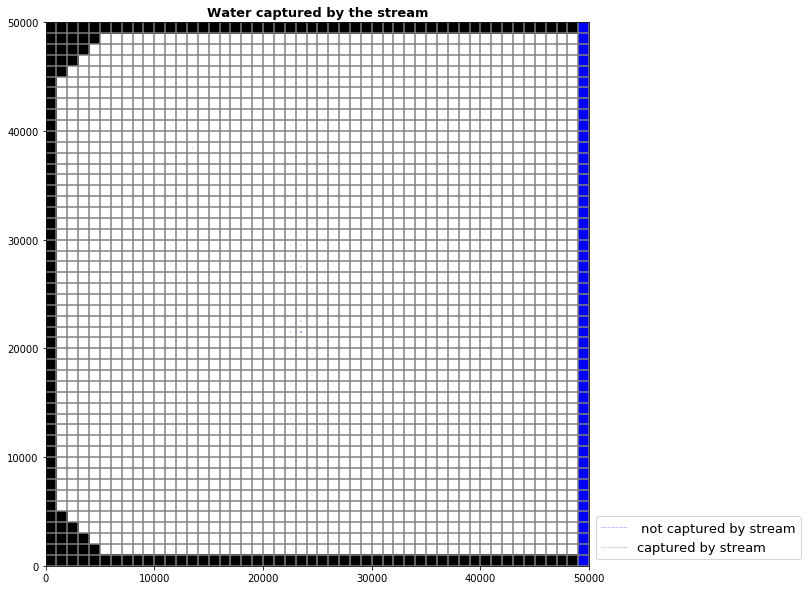

In [6]:
#set up variable lists
#K upper and lower layers (isotropic) and horiz k middle layer list
k_ulm = [5 , 100 , 100 , 5 , 25 , 25 , 25 , 25 , 25 , 5]
#vertical K middle layer list
vka_mid = [1 , 1e-06 , 1e-06 , 1e-06 , 1e-06 , 1e-06 , 1e-06 , 1e-02 , 1e-02 , 1e-06]
#specific yield list 
sy = [0.3 , 0.3 , 0.05 , 0.05 , 0.1 , 0.1 , 0.1 , 0.05 , 0.05 , 0.05]
#mountain recharge list
mrr = [5e-05 , 5e-05 , 1e-05 , 1e-05 , 1e-05 , 1e-05 , 3e-05 , 5e-05 , 1e-05 , 1e-05]
#Valley ET rate list 
vetr = [1e-06 , 1e-06 , 1e-04 , 1e-04 , 1e-04 , 1e-04 , 1e-06 , 1e-05 , 1e-05 , 1e-06]
#Riparian ET rate list
retr = [1 , 1 , 3 , 3 , 3 , 1 , 1 , 2 , 2 , 1]
#streambed K list
streambed_k = [1 , 1 , 1e-02 , 1e-02 , 1e-02 , 1e-02 , 1e-02 , 1 , 1e-02 , 1e-02]

HEAD_adv1p={}
STORAGE_adv1p={}
LEAKAGE_adv1p={}
ET_DATA_adv1p={}
FRF_adv1p={}
FFF_adv1p={}
RECHARGE_DATA_adv1p={}
ET_TIME_SERIES_adv1p={}
TIME_SERIES_adv1p={}
STORAGE_SERIES_adv1p={}
RECHARGE_adv1p={}


#loop start
# for x in range(2,4):
# for x in range(1):
x=7
modelname = "Advocacy1p_" + str(x + 1)
#    moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
#moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"
moddir="C:\WRDAPP\MODFLOW\mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                           delr=dx, delc=dy, top=ztop, botm=botm, 
                           itmuni = 4, lenuni = 2, 
                           nper=nper, steady=steady, perlen=perlen, nstp=nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)





# setting up layer properties 
Sy = sy[x]

K_horiz = k_ulm[x] #m/d
K_vert = k_ulm[x] #m/d
K_vert2 = vka_mid[x] #m/d  #K for the middle layer 


# make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
Kz[1,:,:] = K_vert2

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                           vka=Kz, ss=Ss,
                           sy=Sy,storagecoefficient=True, ipakcb=53)




## ET set up
ET = vetr[x] / 2 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= retr[x] / 2 #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)


rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
ET_dict={}
for p in range(0,nper):
    ET_dict[p]=ET_zone

#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_dict, exdp=extinction_depth, ipakcb=53) 




# Recharge - will be done in the loop
rech= mrr[x]  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

###REFLECTING THE FARM FOR DESIGN ONE
agrech_rows_forced = (19.0, 21.0) #rech zone forced for leftmost 15 cols
agrech_cols_forced = (18.0, 20.0)
agrech = 0.00015  #pistachios (1/8th area already included)

rech_zone_no_ag = np.zeros((1, nrow,ncol))
rech_zone_ag = np.zeros((1, nrow,ncol))

rech_zone_no_ag[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech

rech_zone_ag[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
rech_zone_ag[0, int(agrech_rows_forced[0]):int(agrech_rows_forced[1]),int(agrech_cols_forced[0]):int(agrech_cols_forced[1])]=agrech


R = {}                                             # create empty dictionary for recharge fluxes
for p in range(0,nper):                            # loop over stress periods, skipping initial steady state defined above
    if (p < 600):
        R[p]=rech_zone_no_ag
    else:
        R[p]=rech_zone_ag


#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=R, ipakcb=53)     #create rch object



#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = streambed_k[x] #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])

#create dictionary of stress period data
riv_spd = {0: riv_sp}

#River - riv
riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

#Well - wel
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)


#oc package
oc_spd = {}
for kper in range(0, nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']

oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)


#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=5000, iter1=100, relax = 0.95, damp = 0.1)


#write the inputs
m.write_input()   
m.check()



#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')# if not success:
#     continue # start over on next loop if model fails to converge



#Read in files from the run 

hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()                               # returns a list of timesteps

#extract binary data from head file
head = {} #create dictionary to store head data 
frf = {} #create dictionary to store flows through right cell face 
fff = {} #create dictionary to store flows through front cell face 
storage = {} #create dictionary to store storage
ET = {}
recharge = {}
leakage = {}

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data() #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) 
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
#         storage['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
    ET['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
    recharge['sp%s'%(stress_per)] = budgobj.get_data(text='RECHARGE',totim=time)
    leakage['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time)

#Plot head at monitoring wells 
#get time series for a certain cell

cell_id1 = (0,25,24) #cell ID of MW1
cell_id2 = (0,37,12) #cell ID of MW2
ag_id = (0,38,12)#cell ID of ag well
agua_id = (2,29,37) #Cell ID of aguaseca community well

time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
time_series_agua = headobj.get_ts(agua_id) #get the time series at agua seca com well
time_series={'MW1': [time_series1],'MW2': [time_series2],
             'ag_well': [time_series_ag],'agua_well': [time_series_agua]}

#ET things
ET_data = budgobj.get_data(text='ET')
#print(np.sum(ET_data[0]))
ET_time_series = []
x_val = []
for i in (range(len(ET_data))):
    test_sum = np.sum(ET_data[i])
    if test_sum == 2500:
        print("skipped")
    else:
        ET_time_series.append(test_sum)
        x_val.append(i)
#             print("attached")

#Recharge things
Recharge_data = budgobj.get_data(text='RECHARGE')
print("The final recharge sum for",str(modelname),'is',np.sum(Recharge_data[len(Recharge_data)-1]))    

#Leakage things 
leakage = budgobj.get_data(text='RIVER LEAKAGE')
position = len(leakage)-1
leak=leakage[position]
tot_leak = sum(leak.q)

#Storage things 
storage = budgobj.get_data(text='STORAGE')
storage_series = []

x_val_stor = []
for n in (range(len(storage))):
    #print("The storage sum at ",x,'is',np.sum(storage[x]))
    test_sum = np.sum(storage[n])
    storage_series.append(test_sum)
    x_val_stor.append(n)
sum_storage = sum(storage_series)


print("Total Daily flux from river to groundwater in the final year for",str(modelname),"is", round(tot_leak,2), "m3/day")

#Adding Particles
moddirmp="C:\WRDAPP\modpath_7_2_001\mpath7"
mpname=os.path.join(modelname + '_mp')

locsb = [[0, 0, 0, 0, nrow - 1, ncol-1]]
#set the number of particles per cell
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=1, rowcelldivisions=1, layercelldivisions=1)
#setup theparticles
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg2 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg2]

defaultiface = {'RECHARGE': 6, 'ET': 6}

#setup  the modpath packages
mp = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)

mp.add_package(rch)
mp.write_input()
mp.run_model()
mp.get_package_list()


#Reading Particle Data
#load in the flow path file
fpth = os.path.join(mpname + '.mppth')
p = flopy.utils.PathlineFile(fpth)

#load in the end point file
fpth = os.path.join(mpname + '.mpend')
e = flopy.utils.EndpointFile(fpth, verbose=False)

#make a subset which is all the particles
pall = p.get_alldata()  #formerly pwb and ewb
eall = e.get_alldata()

#make a subset which is the partlces that end in the well 
rivernodes = list(range(1201, 1250))
#print(rivernodes)
priver = p.get_destination_pathline_data(dest_cells=rivernodes)
eriver= e.get_destination_endpoint_data(dest_cells=rivernodes)


# Ploting Pathlines ending in river
fig = plt.figure(figsize=(10, 10))
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()

modelmap.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label=' not captured by stream') #,marker='o', markercolor='black', markersize=3, markerevery=5)
modelmap.plot_pathline(priver, layer='all', color='green', lw=0.5, linestyle=':', label='captured by stream') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
modelmap.ax.legend(loc='lower left', bbox_to_anchor=(1, 0.00),fontsize=13);
plt.title('Water captured by the stream',fontweight='bold',fontsize=13)

# plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
#                    mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black')],)

plt.show(modelmap)





    # save each run's dictionaries in dictionaries

#     HEAD_adv1p[x+1] = head
#     STORAGE_adv1p[x+1] = storage
#     LEAKAGE_adv1p[x+1] = leakage
#     ET_DATA_adv1p[x+1] = ET_data
#     FRF_adv1p[x+1] = frf
#     FFF_adv1p[x+1] = fff
#     RECHARGE_DATA_adv1p[x+1] = Recharge_data
#     ET_TIME_SERIES_adv1p[x+1] = ET_time_series
#     TIME_SERIES_adv1p[x+1] = time_series
#     STORAGE_SERIES_adv1p[x+1] = storage_series
#     RECHARGE_adv1p[x+1] = recharge
    

    # Save each run's dictionaries as pickles
    
#     Pickle_1 = 'head_Advocacy_' + str(x + 1) + '.pickle'
#     Pickle_2 = 'storage_Advocacy_' + str(x + 1) + '.pickle'
#     Pickle_3 = 'leakage_Advocacy_' + str(x + 1) + '.pickle'
#     Pickle_4 = 'ET_Data_Advocacy_' + str(x + 1) + '.pickle'
#     Pickle_5 = 'frf_Advocacy_' + str(x + 1) + '.pickle'
#     Pickle_6 = 'fff_Advocacy_' + str(x + 1) + '.pickle'
#     Pickle_7 = 'Rheadecharge_data_Advocacy_' + str(x + 1) + '.pickle'
#     Pickle_8 = 'ET_TS_Advocacy_' + str(x + 1) + '.pickle'
#     Pickle_9 = 'TS_Advocacy_' + str(x + 1) + '.pickle'
#     Pickle_10 = 'storage_series_Advocacy_' + str(x + 1) + '.pickle'
#     Pickle_11 = 'recharge_Advocacy_' + str(x + 1) + '.pickle'
    
#     with open(Pickle_1, 'wb') as f:
#         pickle.dump(head, f)

#     with open(Pickle_2, 'wb') as f:
#         pickle.dump(storage, f)

#     with open(Pickle_3, 'wb') as f:
#         pickle.dump(leakage, f)

#     with open(Pickle_4, 'wb') as f:
#         pickle.dump(ET_data, f)

#     with open(Pickle_5, 'wb') as f:
#         pickle.dump(frf, f)

#     with open(Pickle_6, 'wb') as f:
#         pickle.dump(fff, f)

#     with open(Pickle_7, 'wb') as f:
#         pickle.dump(Recharge_data, f)
        
#     with open(Pickle_8, 'wb') as f:
#         pickle.dump(ET_time_series, f)
        
#     with open(Pickle_9, 'wb') as f:
#         pickle.dump(time_series, f)
    
#     with open(Pickle_10, 'wb') as f:
#         pickle.dump(storage_series, f)
        
#     with open(Pickle_11, 'wb') as f:
#         pickle.dump(recharge, f)
    

In [7]:
# with open('HEAD_Advocacy1p.pickle', 'wb') as f:
#     pickle.dump(HEAD_adv1p, f)

# with open('STORAGE_Advocacy1p.pickle', 'wb') as f:
#     pickle.dump(STORAGE_adv1p, f)

# with open('LEAKAGE_Advocacy1p.pickle', 'wb') as f:
#     pickle.dump(LEAKAGE_adv1p, f)

# with open('ET_DATA_Advocacy1p.pickle', 'wb') as f:
#     pickle.dump(ET_DATA_adv1p, f)

# with open('FRF_Advocacy1p.pickle', 'wb') as f:
#     pickle.dump(FRF_adv1p, f)

# with open('FFF_Advocacy1p.pickle', 'wb') as f:
#     pickle.dump(FFF_adv1p, f)

# with open('RECHARGE_DATA_Advocacy1p.pickle', 'wb') as f:
#     pickle.dump(RECHARGE_DATA_adv1p, f)

# with open('ET_TIME_SERIES_Advocacy1p.pickle', 'wb') as f:
#     pickle.dump(ET_TIME_SERIES_adv1p, f)

# with open('TIME_SERIES_Advocacy1p.pickle', 'wb') as f:
#     pickle.dump(TIME_SERIES_adv1p, f)

# with open('STORAGE_SERIES_Advocacy1p.pickle', 'wb') as f:
#     pickle.dump(STORAGE_SERIES_adv1p, f)

# with open('RECHARGE_Advocacy1p.pickle', 'wb') as f:
#     pickle.dump(RECHARGE_adv1p, f)


In [8]:
# print(HEAD.keys())
# print(HEAD[1]['sp1'])

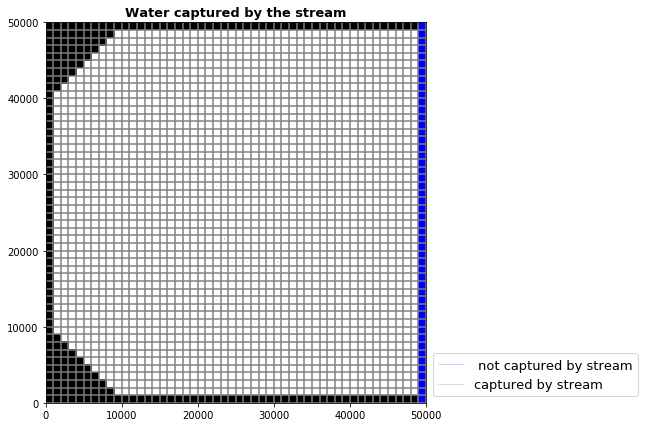

In [11]:


# Ploting Pathlines ending in river
fig = plt.figure(figsize=(7, 7))
modelmap = flopy.plot.PlotMapView(model=m, layer=2)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()

modelmap.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label=' not captured by stream') #,marker='o', markercolor='black', markersize=3, markerevery=5)
modelmap.plot_pathline(priver, layer='all', color='green', lw=0.5, linestyle=':', label='captured by stream') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
modelmap.ax.legend(loc='lower left', bbox_to_anchor=(1, 0.00),fontsize=13);
plt.title('Water captured by the stream',fontweight='bold',fontsize=13)

# plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
#                    mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black')],)

plt.show(modelmap)
